Deep Reinforcement Learning for Trading with TensorFlow 2.0

Based on: https://www.mlq.ai/deep-reinforcement-learning-for-trading-with-tensorflow-2-0/

and: https://www.mlq.ai/deep-reinforcement-learning-for-trading/

RL: https://www.mlq.ai/what-is-reinforcement-learning/

Code reference: https://github.com/edwardhdlu/q-trader

To Do:  
- Explore foundations of Q-learning
- Explore routes to parallelization 
- Implement proper logging and find why terminal keeps crashing, scale to larger networks


In [1]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
from collections import deque

In [2]:
print("TensorFlow Version: ", tf.__version__)

from tensorflow.python.client import device_lib
print("GPUs: ", device_lib.list_local_devices())

TensorFlow Version:  2.0.0
GPUs:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10759959310561125645
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4855863705
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6429976486617170260
physical_device_desc: "device: 0, name: GeForce GTX 1660 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


In [3]:
class AI_Trader():
    def __init__(self, state_size, action_space=3, model_name="AITrader"):
        self.state_size = state_size # alt
        self.action_space = action_space
        self.memory = deque([], maxlen=2000)
        self.inventory = []
        self.model_name = model_name # alt
        
        self.gamma = 0.95 # alt
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.995
        
        self.model = self.model_builder()
        
    def model_builder(self):
        model = tf.keras.models.Sequential()

        model.add(tf.keras.layers.Dense(units=8, activation='relu', input_dim=self.state_size))
        #model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        #model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        #model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))

        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001))
        return model
    
    def trade(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_space)
        
        actions = self.model.predict(state)
        return np.argmax(actions[0])
        
        
    def batch_trade(self, batch_size):
        batch = []
        for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
            batch.append(self.memory[i])
  
        for state, action, reward, next_state, done in batch:
            reward = reward
            if not done:
                reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
    
            target = self.model.predict(state)
            target[0][action] = reward
  
            self.model.fit(state, target, epochs=1, verbose=0) # Why only 1 epoch?
  
        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

In [4]:
'''
Two changes to make: 
1) Handle any stock from datapull
2) Return more than closing price (modify NN)
'''

def dataset_loader(stock_name="AMZN"):

    dataset = pd.read_csv("AMZN_intraday.csv")
    close = dataset['4. close']
  
    return close

In [5]:
def stock_price_format(n):
    if n < 0:
        return "- $ {0:2f}".format(abs(n))
    else:
        return "$ {0:2f}".format(abs(n))

In [6]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [7]:
def state_creator(data, timestep, window_size):
  
    starting_id = timestep - window_size + 1
  
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep+1].reset_index(drop=True)
    else:
        windowed_data = -1*starting_id * [data[0]] + list(data[0:timestep+1])
    
    state = []
    for i in range(window_size - 1):
        state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))
    
    return np.array([state])

Training the Agent

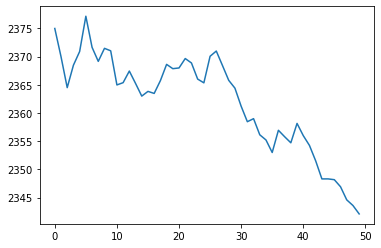

In [8]:
data = dataset_loader()
data = data[:50]
plt.plot(data)

In [9]:
window_size = 10
episodes = 100

batch_size = 32
data_samples = len(data) - 1

In [10]:
trader = AI_Trader(window_size)
trader.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 88        
Total params: 88
Trainable params: 88
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for episode in range(1, episodes + 1):
  
    print("Episode: {}/{}".format(episode, episodes))
  
    state = state_creator(data, 0, window_size + 1)
  
    total_profit = 0
    trader.inventory = []
  
    # for t in tqdm(range(data_samples)):
    for t in range(data_samples):
        print("t: ", t)
        
        action = trader.trade(state)
            
        next_state = state_creator(data, t+1, window_size + 1)
        reward = 0
    
        if action == 1: #Buying
            trader.inventory.append(data[t])
            print("AI Trader bought: ", stock_price_format(data[t]))
      
        elif action == 2 and len(trader.inventory) > 0: #Selling
            buy_price = trader.inventory.pop(0)
      
            reward = max(data[t] - buy_price, 0)
            total_profit += data[t] - buy_price
            print("AI Trader sold: ", stock_price_format(data[t]), " Profit: " + stock_price_format(data[t] - buy_price) )
      
        if t == data_samples - 1:
            done = True
        else:
            done = False
      
        trader.memory.append((state, action, reward, next_state, done))
    
        state = next_state
    
        if done:
            print("########################")
            print("TOTAL PROFIT: {}".format(total_profit))
            print("########################")
    
        if len(trader.memory) > batch_size:
            trader.batch_trade(batch_size)
      
    if episode % 10 == 0:
        trader.model.save("ai_trader_{}.h5".format(episode))

Episode: 1/100
t:  0
AI Trader bought:  $ 2374.990000
t:  1
t:  2
AI Trader sold:  $ 2364.500000  Profit: - $ 10.490000
t:  3
AI Trader bought:  $ 2368.480500
t:  4
AI Trader sold:  $ 2370.905000  Profit: $ 2.424500
t:  5
t:  6
AI Trader bought:  $ 2371.649900
t:  7
AI Trader sold:  $ 2369.159900  Profit: - $ 2.490000
t:  8
t:  9
t:  10
t:  11
t:  12
t:  13
AI Trader bought:  $ 2365.250000
t:  14
AI Trader sold:  $ 2363.000000  Profit: - $ 2.250000
t:  15
AI Trader bought:  $ 2363.835000
t:  16
t:  17
AI Trader sold:  $ 2365.740000  Profit: $ 1.905000
t:  18
t:  19
t:  20
t:  21
t:  22
t:  23
t:  24
t:  25
t:  26
t:  27
t:  28
t:  29
t:  30
t:  31
AI Trader bought:  $ 2358.460000
t:  32
AI Trader sold:  $ 2359.000000  Profit: $ 0.540000
t:  33
AI Trader bought:  $ 2356.139900
t:  34
t:  35
AI Trader sold:  $ 2353.000000  Profit: - $ 3.139900
t:  36
t:  37
AI Trader bought:  $ 2355.799800
t:  38
t:  39
AI Trader sold:  $ 2358.156300  Profit: $ 2.356500
t:  40
t:  41
t:  42
t:  43
t:  44